<div style="text-align:center;padding:20px;color:Seashell;font-size:48px;font-family:Roboto Condensed;background-color:Sienna;margin:0;overflow:hidden;border:4px solid Seashell;border-radius:10px;">S04E01 🏦👨‍💼 Bank Churn Binary-Class</div>

<table style="width:100%;table-layout:fixed;margin:0;overflow:hidden;text-align:center;font-family:Roboto Condensed;font-size:18px"><tr>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Task</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Method</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Target</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Feature</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Train</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Test</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Metric</th>
<th style="width:12.5%;background-color:Seashell;color:Sienna;border:2px solid Sienna;text-align:center;">Result</th></tr><tr>
<th style="border: 2px solid Sienna; text-align: center;">BinaryClass </td>
<th style="border: 2px solid Sienna; text-align: center;">LGB+XGB     </td>
<th style="border: 2px solid Sienna; text-align: center;">0/1         </td>
<th style="border: 2px solid Sienna; text-align: center;">12          </td>
<th style="border: 2px solid Sienna; text-align: center;">165034      </td>
<th style="border: 2px solid Sienna; text-align: center;">110023      </td>
<th style="border: 2px solid Sienna; text-align: center;">AUC         </td>
<th style="border: 2px solid Sienna; text-align: center;">89.5%       </td></tr></table>

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">01 - Data - Importing</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, log_loss, accuracy_score, roc_auc_score
from itertools import combinations

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc = {'axes.facecolor': '#f8f2e4', 'figure.facecolor': '#f8f2e4', 'font.family': 'serif',
        'axes.edgecolor': '#595959', 'axes.labelcolor': '#595959', 'axes.titlecolor': '#595959',
        'xtick.color': '#595959', 'ytick.color': '#595959', 'grid.color': '#595959', 'grid.alpha': 0.1})

styles = [{'selector': 'th, td', 'props': [('width', '60px'), ('text-align', 'center')]}]

palette = sns.color_palette('colorblind')

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

print('train',train.shape)
print('test',test.shape)
print('sub',sub.shape)

train (165034, 13)
test (110023, 12)
sub (110023, 2)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


In [5]:
train.head(6).T

,0,1,2,3,4,5
CustomerId,15674932,15749177,15694510,15741417,15766172,15771669
Surname,Okwudilichukwu,Okwudiliolisa,Hsueh,Kao,Chiemenam,Genovese
CreditScore,668,627,678,581,716,588
Geography,France,France,France,France,Spain,Germany
Gender,Male,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0,36.0
Tenure,3,1,10,2,5,4
Balance,0.0,0.0,0.0,148882.54,0.0,131778.58
NumOfProducts,2,2,2,1,2,1
HasCrCard,1.0,1.0,1.0,1.0,1.0,1.0


## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">02 - Data - Description</div>

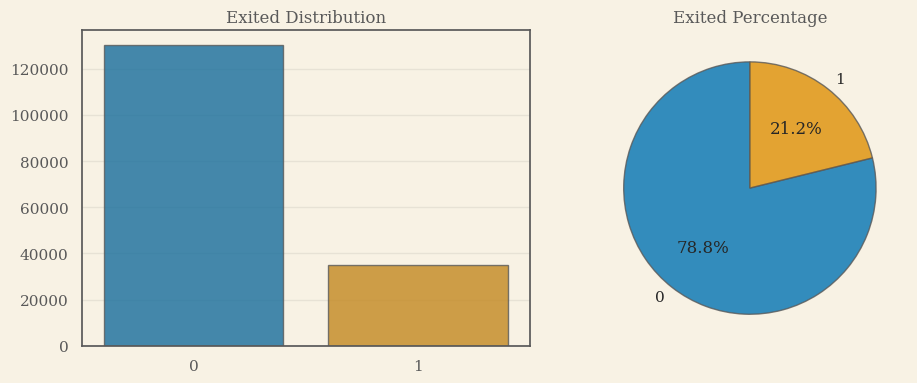

In [6]:
target = 'Exited'

target_counts = train[target].value_counts().reset_index()
target_counts.columns = [target, 'Count']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=target_counts, x=target, y='Count', ax=axes[0], palette=palette, edgecolor='#595959', alpha=0.8)
axes[0].set_title(f'{target} Distribution')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

axes[1].pie(target_counts['Count'], labels=target_counts[target], autopct='%1.1f%%',
            colors=palette, startangle=90, wedgeprops={'edgecolor': '#595959', 'alpha': 0.8})
axes[1].set_title(f'{target} Percentage')

plt.tight_layout()
plt.show()

In [7]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0
0
0


In [8]:
def summary(train):
    print(f'Shape: {train.shape}')
    df = pd.DataFrame()
    numeric_cols = train.select_dtypes(include=[np.number])
    desc = numeric_cols.describe().transpose()
    df['Type'] = train.dtypes
    df['Mean'] = desc['mean'].round(1)
    df['Unique'] = train.nunique().values
    df['Null'] = train.isnull().sum().values
    df['Skew'] = numeric_cols.skew().round(1)

    for col in numeric_cols.columns:
        Q1 = desc.loc[col, '25%']
        Q3 = desc.loc[col, '75%']
        IQR = Q3 - Q1
        df.loc[col, '<6IQR'] = (numeric_cols[col] < Q1 - 6 * IQR).sum()
        df.loc[col, '<3IQR'] = (numeric_cols[col] < Q1 - 3 * IQR).sum()
        df.loc[col, '>3IQR'] = (numeric_cols[col] > Q3 + 3 * IQR).sum()
        df.loc[col, '>6IQR'] = (numeric_cols[col] > Q3 + 6 * IQR).sum()
    df['Min'] = desc['min'].round(1)
    df['Median'] = desc['50%'].round(1)
    df['Max'] = desc['max'].round(1)
    return df

In [9]:
column_mapping = {
    'HasCrCard': 'Card',
    'IsActiveMember': 'Member',
    'NumOfProducts': 'Products',
    'CreditScore': 'Score',
    'EstimatedSalary': 'Salary',
}
train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)

In [10]:
summary(train.drop([target], axis=1)).sort_values(by='Unique', ascending=True).style.format(
    precision=1).background_gradient(cmap='Oranges').set_table_styles(styles)

Shape: (165034, 12)


,Type,Mean,Unique,Null,Skew,<6IQR,<3IQR,>3IQR,>6IQR,Min,Median,Max
Gender,object,nan,2,0,nan,nan,nan,nan,nan,nan,nan,nan
Card,float64,0.8,2,0,-1.2,40606.0,40606.0,0.0,0.0,0.0,1.0,1.0
Member,float64,0.5,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Geography,object,nan,3,0,nan,nan,nan,nan,nan,nan,nan,nan
Products,int64,1.6,4,0,0.4,0.0,0.0,0.0,0.0,1.0,2.0,4.0
Tenure,int64,5.0,11,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0
Age,float64,38.1,71,0,1.0,0.0,0.0,313.0,0.0,18.0,37.0,92.0
Score,int64,656.5,457,0,-0.1,0.0,0.0,0.0,0.0,350.0,659.0,850.0
Surname,object,nan,2797,0,nan,nan,nan,nan,nan,nan,nan,nan
CustomerId,int64,15692005.0,23221,0,-0.0,0.0,0.0,0.0,0.0,15565701.0,15690169.0,15815690.0


In [11]:
summary(test).sort_values(by='Unique', ascending=True).style.format(
    precision=1).background_gradient(cmap='Oranges').set_table_styles(styles)

Shape: (110023, 12)


,Type,Mean,Unique,Null,Skew,<6IQR,<3IQR,>3IQR,>6IQR,Min,Median,Max
Gender,object,nan,2,0,nan,nan,nan,nan,nan,nan,nan,nan
Card,float64,0.8,2,0,-1.2,27171.0,27171.0,0.0,0.0,0.0,1.0,1.0
Member,float64,0.5,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Geography,object,nan,3,0,nan,nan,nan,nan,nan,nan,nan,nan
Products,int64,1.6,4,0,0.4,0.0,0.0,0.0,0.0,1.0,2.0,4.0
Tenure,int64,5.0,11,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0
Age,float64,38.1,74,0,1.0,0.0,0.0,218.0,0.0,18.0,37.0,92.0
Score,int64,656.5,454,0,-0.1,0.0,0.0,0.0,0.0,350.0,660.0,850.0
Surname,object,nan,2708,0,nan,nan,nan,nan,nan,nan,nan,nan
CustomerId,int64,15692096.6,19698,0,-0.0,0.0,0.0,0.0,0.0,15565701.0,15690175.0,15815690.0


## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">03 - Distribution - Category</div>

In [12]:
train1 = train.copy()
test1 = test.copy()

In [13]:
def cat_plot(train, cat_features, target):
    num_rows = len(cat_features)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2.5 * num_rows))
    axes = axes.reshape(-1, 2)

    for i, feature in enumerate(cat_features):

        sns.countplot(x=train[feature], ax=axes[i][0], color=palette[0], edgecolor='black', alpha=0.8)
        axes[i][0].set_title(f'{feature}')
        axes[i][0].set_xlabel('')
        axes[i][0].set_ylabel('')
        axes[i][0].tick_params(labelsize=8)

        cross = pd.crosstab(train[feature], train[target], normalize='index')
        cross.plot(kind='bar', stacked=True, ax=axes[i][1], color=palette, edgecolor='black', alpha=0.8)
        axes[i][1].set_title('Target')
        axes[i][1].set_xlabel('')
        axes[i][1].set_ylabel('')
        axes[i][1].tick_params(rotation=0, labelsize=8)
        axes[i][1].set_ylim(0, 1.3)
        axes[i][1].legend(loc='upper center', ncol=4, fontsize=8)

    plt.tight_layout()
    plt.show()

In [14]:
cat_features = train1.columns[train1.nunique() <= 15].drop([target]).tolist()
cat_features

['Geography', 'Gender', 'Tenure', 'Products', 'Card', 'Member']

In [15]:
def cat_preprocess(df):

    df['Geography'] = df['Geography'].replace({'Germany': 0, 'Spain': 1, 'France': 2}).astype(int)

    df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)

    df['Card'] = df['Card'].astype(int)    

    df['Member'] = df['Member'].astype(int)    
    
    return df

train1 = cat_preprocess(train1)
test1 = cat_preprocess(test1)

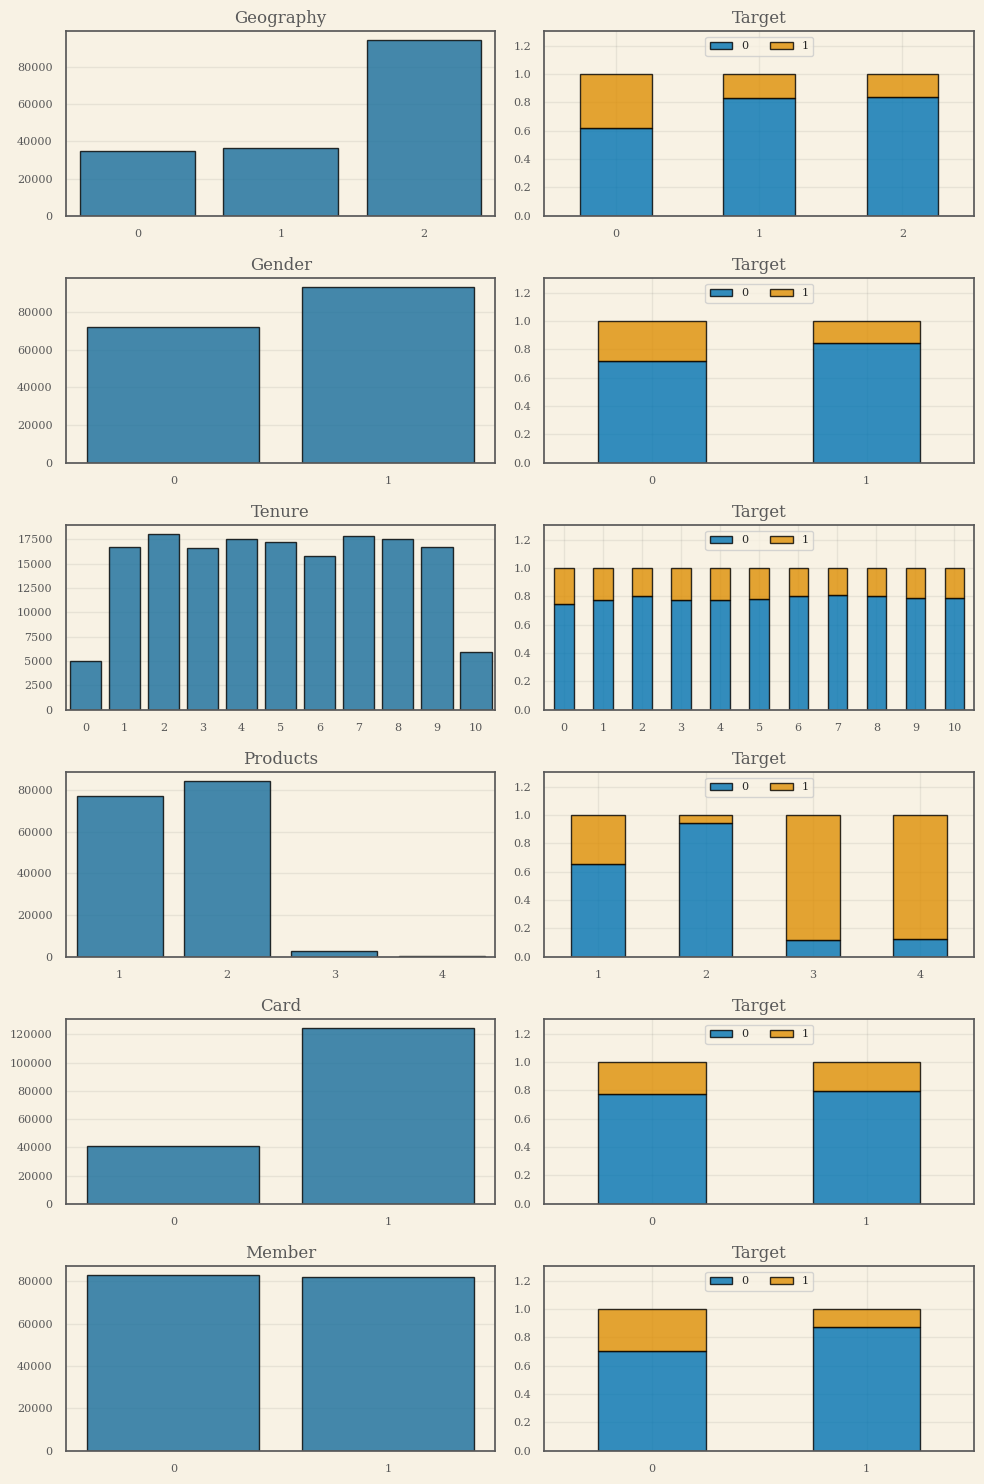

In [16]:
cat_plot(train1, cat_features, target)

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">04 - Distribution - Numeric</div>

In [17]:
def num_plot(train, num_features, target):
    num_rows = len(num_features)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2.5 * num_rows))
    axes = axes.reshape(-1, 2)

    for i, feature in enumerate(num_features):
        bins = pd.cut(train[feature], bins=15, precision=0)
        labels = [f'{interval.right}' for interval in bins.cat.categories]
        bin = train.copy()
        bin[feature] = pd.cut(train[feature], bins=15, labels=labels)

        sns.countplot(x=bin[feature], ax=axes[i][0], color=palette[0],
                      edgecolor='black', alpha=0.8)
        axes[i][0].set_title(f'{feature}')
        axes[i][0].set_xlabel(''), axes[i][0].set_ylabel(''), axes[i][0].tick_params(labelsize=9)

        cross = pd.crosstab(bin[feature], bin[target], normalize='index')
        cross.plot(kind='bar', stacked=True, ax=axes[i][1], color=palette,
                   edgecolor='black', alpha=0.8)
        axes[i][1].set_title('Target')
        axes[i][1].set_xlabel(''), axes[i][1].set_ylabel('')
        axes[i][1].tick_params(axis='x', rotation=0), axes[i][1].tick_params(labelsize=9)
        axes[i][1].set_ylim(0, 1.3)
        axes[i][1].legend(loc='upper center', ncol=4, fontsize=8)

    plt.tight_layout()
    plt.show()

In [18]:
num_features = train1.columns[train1.nunique() > 15].tolist()
num_features
num_features = ['Score', 'Age', 'Balance', 'Salary']

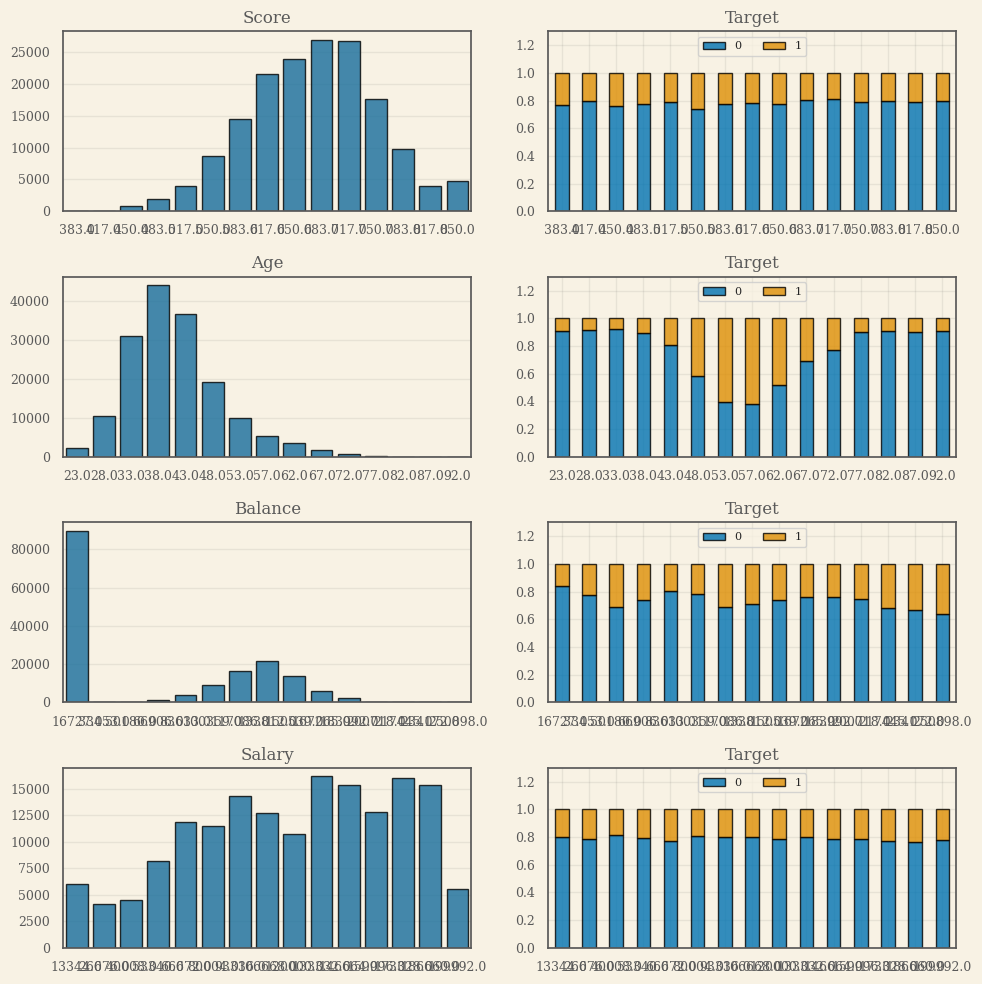

In [19]:
num_plot(train1, num_features, target)

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">05 - Feature - Correlation</div>

In [20]:
train2 = train1.copy()
test2 = test1.copy()

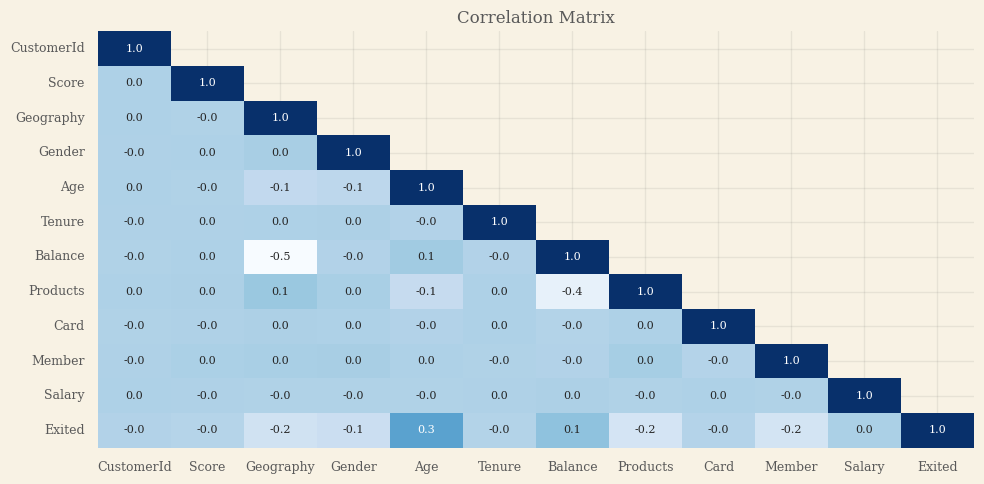

In [21]:
correlation_matrix = train2.select_dtypes(include=['number']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".1f", cmap='Blues', cbar=False, annot_kws={"size": 8})
plt.xticks(rotation=0)
plt.tick_params(labelsize=9)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [22]:
def pair_plot(train, feature1, feature2, target):
    fig, axes = plt.subplots(figsize=(6, 3))
    sns.scatterplot(data=train, x=feature1, y=feature2, hue=target, palette=palette, edgecolor='black', alpha=0.8)
    axes.set_title(f'{feature1} vs {feature2}')
    axes.set_xlabel(feature1), axes.set_ylabel(feature2)
    axes.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [23]:
correlation = train2.select_dtypes(include=['number']).corr()[target].abs().sort_values(ascending=False)
correlation.head(20).drop(target)

Age           0.340768
Products      0.214554
Member        0.210237
Geography     0.186849
Gender        0.146442
Balance       0.129743
Score         0.027383
Card          0.022141
Tenure        0.019565
Salary        0.018827
CustomerId    0.009947
Name: Exited, dtype: float64

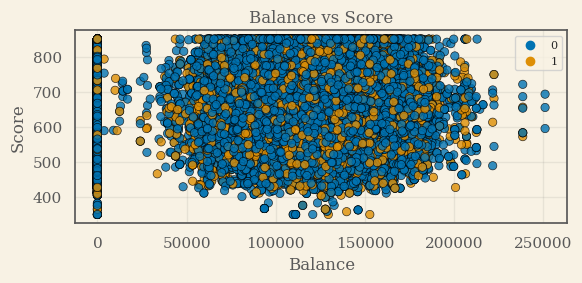

In [24]:
pair_plot(train2, 'Balance', 'Score', target)

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">06 - Feature - Engineering</div>

In [25]:
train2 = train1.copy()
test2 = test1.copy()

In [26]:
def new_preprocess(df):

    df['x1'] = df['Age'] * df['Products']

    df['x2'] = df['Salary'] + df['Balance']

    df['x3'] = (df['Balance'] / df['Salary']).clip(upper=15)

    df['x4'] = df['Score'] / df['Age']

    df['x5'] = df['Tenure'] / df['Products']

    df['x6'] = ((df['Geography'] != 0).astype(int) +
                (df['Gender'] == 1).astype(int) +
                (df['Products'] == 2).astype(int) +
                (df['Member'] == 1).astype(int))

    df['x7'] = df['Member'] * df['Card']

    df['x8'] = (df['Age'] // 10).astype(int)
    
    return df

train2 = new_preprocess(train2)
test2 = new_preprocess(test2)

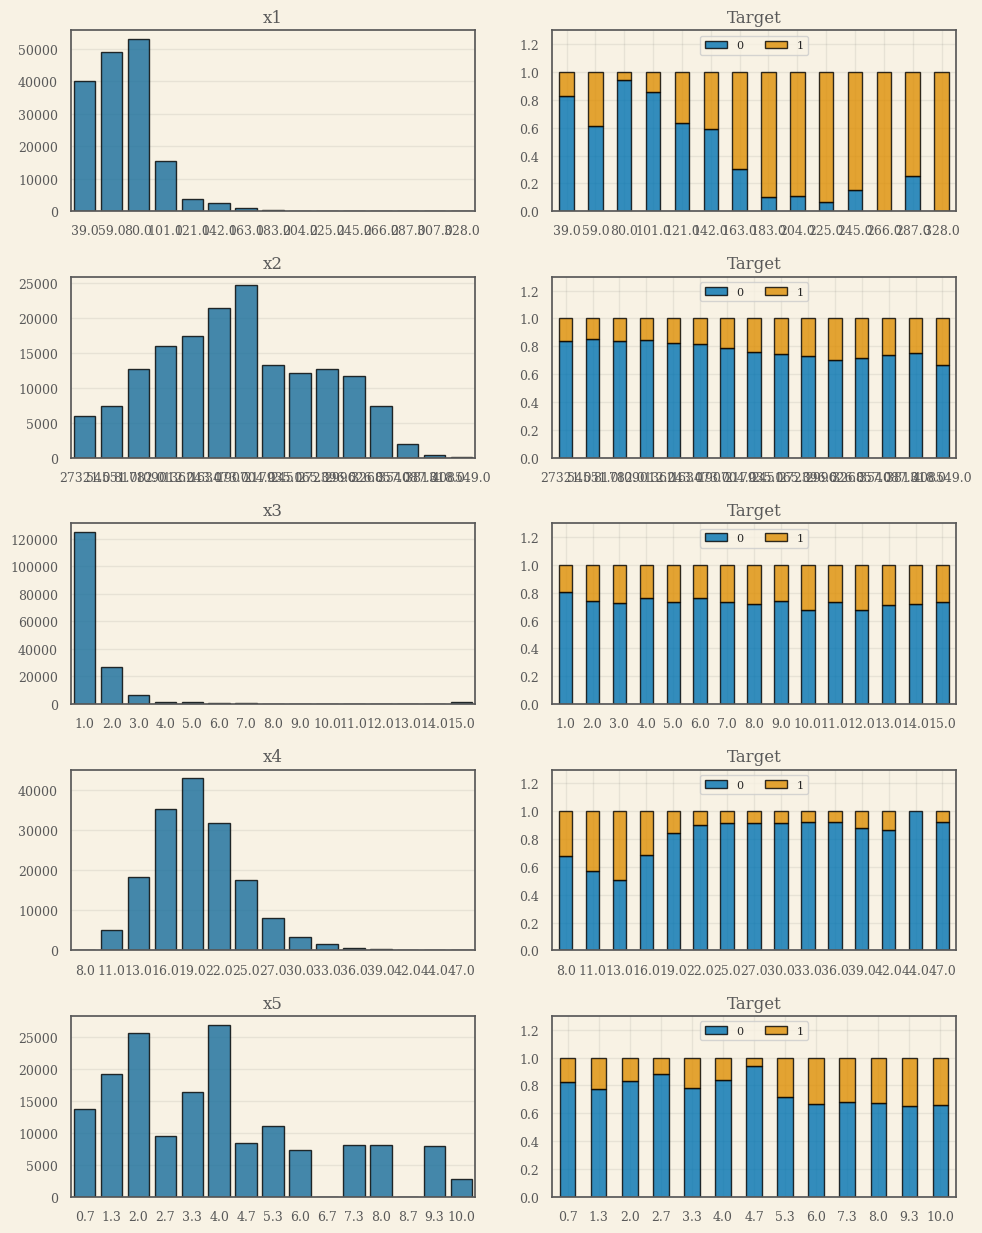

In [27]:
new_features = ['x1', 'x2', 'x3', 'x4', 'x5']
num_plot(train2, new_features, target)

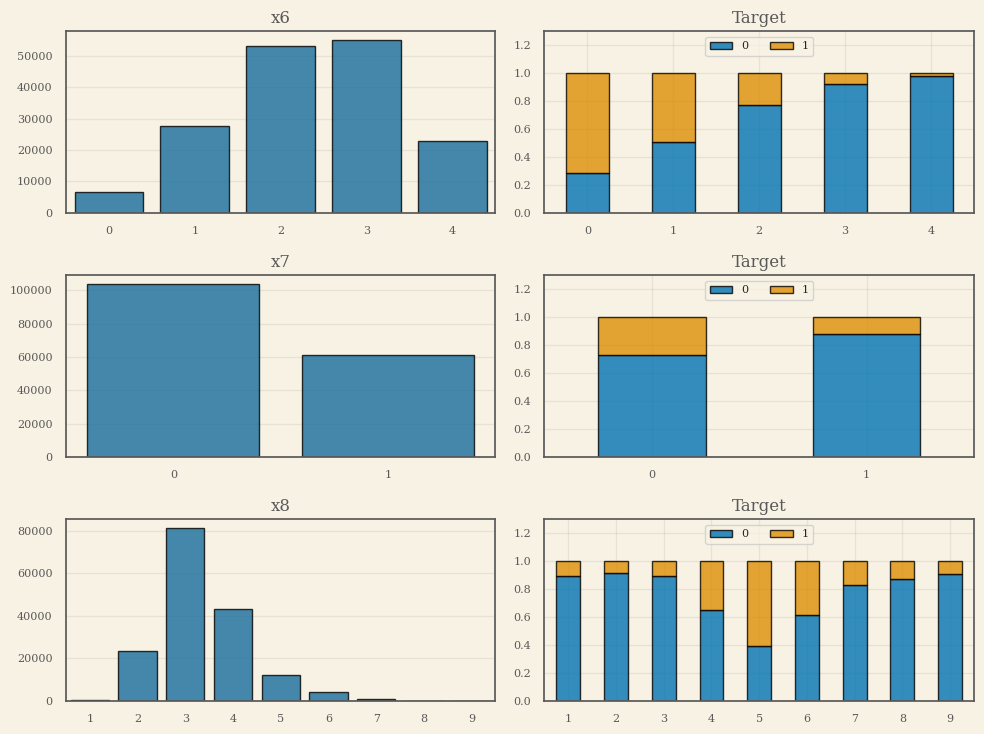

In [28]:
new_features = ['x6', 'x7', 'x8']
cat_plot(train2, new_features, target)

In [29]:
correlation_matrix = train2.select_dtypes(include=['number']).drop([target], axis=1).corr().abs()

upper_triangle_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

upper_triangle_matrix.unstack().sort_values(ascending=False).dropna().head(10)

x8  Age         0.950753
x4  Age         0.824948
x5  Tenure      0.814330
x1  Products    0.814026
x2  Balance     0.782728
x8  x4          0.782480
x7  Member      0.771047
x2  Salary      0.629061
x6  Member      0.547073
    Gender      0.532882
dtype: float64

In [30]:
# aggregation

df = pd.concat([train2, test2], axis=0)

agg_features = {
    'Age': ['min', 'max', 'mean'],       
    'Balance': ['min', 'max', 'mean'],
    'Score': ['min', 'max', 'mean'],
    'Salary': ['min', 'max', 'mean'],
    'Tenure': ['mean','sum'],
    'Products': ['mean','sum'],
    'Card': ['mean','sum'],
    'Member': ['mean','sum']
}

df_agg = df.groupby(['CustomerId', 'Surname', 'Geography']).agg(agg_features).reset_index()

df_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] else col[0] for col in df_agg.columns]

df = df.merge(df_agg, on=['CustomerId', 'Surname', 'Geography'], how='left')

df['Count1'] = df.groupby(['CustomerId', 'Geography'])['CustomerId'].transform('count')
df['Count2'] = df.groupby(['Surname', 'Geography'])['CustomerId'].transform('count')
df['Count3'] = df.groupby(['CustomerId', 'Surname', 'Geography'])['CustomerId'].transform('count')

In [31]:
# scale

scale_features = ['Age', 'Score', 'Balance', 'Salary']
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df[scale_features])
df_scaled = pd.DataFrame(df_scaled, columns=[f"{feature}_scaled" for feature in scale_features])

df = pd.concat([df, df_scaled], axis=1)

df['Surname'] = LabelEncoder().fit_transform(df['Surname']).astype('int')

In [32]:
df.head(6).T

,0,1,2,3,4,5
CustomerId,1.567493e+07,1.574918e+07,1.569451e+07,1.574142e+07,1.576617e+07,1.577167e+07
Surname,1.992000e+03,1.993000e+03,1.217000e+03,1.341000e+03,4.830000e+02,9.710000e+02
Score,6.680000e+02,6.270000e+02,6.780000e+02,5.810000e+02,7.160000e+02,5.880000e+02
Geography,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
Gender,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Age,3.300000e+01,3.300000e+01,4.000000e+01,3.400000e+01,3.300000e+01,3.600000e+01
Tenure,3.000000e+00,1.000000e+00,1.000000e+01,2.000000e+00,5.000000e+00,4.000000e+00
Balance,0.000000e+00,0.000000e+00,0.000000e+00,1.488825e+05,0.000000e+00,1.317786e+05
Products,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00
Card,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [33]:
cat_features =  df.columns[df.nunique() <= 15].drop([target]).tolist()
cat_features

['Geography',
 'Gender',
 'Tenure',
 'Products',
 'Card',
 'Member',
 'x6',
 'x7',
 'x8']

In [34]:
#df = pd.concat([train2, test2], axis=0)

#columns_to_drop = ['']
#df = df.drop(columns=columns_to_drop)

#df = pd.get_dummies(df, columns=cat_features, drop_first=True)

x = df.iloc[:len(train2)].drop([target], axis=1)
y = df.iloc[:len(train2)][target]
x_test = df.iloc[len(train2):].drop([target], axis=1)

print('x', x.shape)
print('y', y.shape)
print('x_test', x_test.shape)

x (165034, 47)
y (165034,)
x_test (110023, 47)


In [35]:
n = 3

kfold = StratifiedKFold(n_splits= n, shuffle=True, random_state=42)

folds = []
for train_idx, valid_idx in kfold.split(x, y):
    x_train, x_valid, y_train, y_valid = x.iloc[train_idx], x.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    folds.append((x_train, x_valid, y_train, y_valid))

print('x_train', x_train.shape)
print('x_valid', x_valid.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)

x_train (110023, 47)
x_valid (55011, 47)
y_train (110023,)
y_valid (55011,)


## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">07 - Model - LightGBM</div>

In [36]:
'''
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 1, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.1, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 64),
        'min_child_samples': trial.suggest_int('min_child_samples', 4, 64),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
    }
    metrics, iterations = [], []
    for x_train, x_valid, y_train, y_valid in folds:
        model = LGBMClassifier(
            **param,
            device_type='gpu',
            n_estimators=2000, objective='binary', random_state=42, verbose=-1)

        model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='auc',
            categorical_feature=cat_features, callbacks=[early_stopping(stopping_rounds=100, verbose=0)])
        metrics.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
        iterations.append(model.best_iteration_)

    print(f'##### auc = {np.mean(metrics):.5f}, iteration = {np.mean(iterations):.0f} #####')
    return np.mean(metrics)

lgb_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
lgb_study.optimize(objective, n_trials=30)

print('-'*10); print(f'best auc: {lgb_study.best_trial.value:.5f}'); print(f'best_param = {lgb_study.best_trial.params}')
'''

"\ndef objective(trial):\n    param = {\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),\n        'max_depth': trial.suggest_int('max_depth', 4, 20),\n        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 1, log=True),\n        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 1, log=True),\n        'min_split_gain': trial.suggest_float('min_split_gain', 0.1, 1, log=True),\n        'num_leaves': trial.suggest_int('num_leaves', 4, 64),\n        'min_child_samples': trial.suggest_int('min_child_samples', 4, 64),\n        'subsample': trial.suggest_float('subsample', 0.4, 1),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),\n    }\n    metrics, iterations = [], []\n    for x_train, x_valid, y_train, y_valid in folds:\n        model = LGBMClassifier(\n            **param,\n            device_type='gpu',\n            n_estimators=2000, objective='binary', random_state=42, verbose=-1)\n\n        model.fit(x_train, y_trai

In [37]:
best_param = {'learning_rate': 0.02, 'max_depth': 15, 'lambda_l1': 0.1596107844959289, 
              'lambda_l2': 0.652763842312636, 'min_split_gain': 0.26445396985303793, 'num_leaves': 18, 
              'min_child_samples': 47, 'subsample': 0.4069725769765318, 'colsample_bytree': 0.4597952276917428}

acc, auc, iter, cm, imp, lgb_valid, lgb_test = [], [], [], [], [], [], []
y_test_proba = np.zeros(x_test.shape[0])

for i, (x_train, x_valid, y_train, y_valid) in enumerate(folds):

    model = LGBMClassifier(
            **best_param,
            device_type='gpu',
            n_estimators=2000, objective='binary', random_state=42, verbose=-1)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='auc',
        categorical_feature=cat_features, callbacks=[early_stopping(stopping_rounds=300, verbose=0)])

    y_valid_pred = model.predict(x_valid)
    y_valid_proba = model.predict_proba(x_valid)[:, 1]
    y_test_proba = model.predict_proba(x_test)[:, 1]

    acc.append(accuracy_score(y_valid, y_valid_pred))
    auc.append(roc_auc_score(y_valid, y_valid_proba))
    iter.append(model.best_iteration_)
    cm.append(confusion_matrix(y_valid, y_valid_pred))
    imp.append(model.feature_importances_)

    lgb_valid.append(y_valid_proba)
    lgb_test.append(y_test_proba)

    print(f'Fold {i+1}: accuracy: {acc[-1]:.5f}, auc: {auc[-1]:.5f}, best_iter: {iter[-1]}')

lgb_proba = np.mean(lgb_test)
lgb_cm = np.sum(cm, axis=0).astype(int)

idx = np.argsort(np.mean(imp, axis=0))[::-1]
lgb_imp = np.mean(imp, axis=0)[idx][:20]
lgb_col = x_train.columns[idx][:20]

print('---')
print(f'Average Accuracy: {np.mean(acc):.5f}')
print(f'Average AUC: {np.mean(auc):.5f}')

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1: accuracy: 0.86828, auc: 0.89561, best_iter: 1901
Fold 2: accuracy: 0.86994, auc: 0.89618, best_iter: 1952
Fold 3: accuracy: 0.87084, auc: 0.89602, best_iter: 1889
---
Average Accuracy: 0.86969
Average AUC: 0.89594


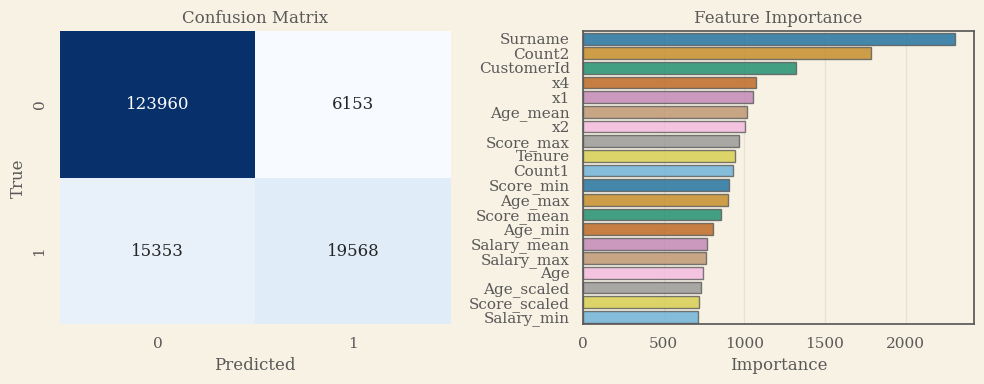

In [38]:
sub[target] = lgb_proba

sub.to_csv('lgb.csv', index=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(lgb_cm, ax=axes[0], annot=True, fmt='d', cmap='Blues', cbar=False)
axes[0].set_title('Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.barplot(x=lgb_imp, y=lgb_col, ax=axes[1], orient='h', palette=palette, edgecolor='#595959', alpha=0.8)
axes[1].set_title('Feature Importance'); axes[1].set_xlabel('Importance'); axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">08 - Model - XGBoost</div>

In [39]:
'''
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 4, 20),

        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),

        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
}
    metrics, iterations = [], []
    for x_train, x_valid, y_train, y_valid in folds:
        model = XGBClassifier(
            **param,
            tree_method='gpu_hist',
            n_estimators=2000, objective='binary:logistic', eval_metric='auc',
            random_state=42, early_stopping_rounds=100)

        model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=0)
        metrics.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
        iterations.append(model.best_iteration)

    print(f'##### auc = {np.mean(metrics):.5f}, iteration = {np.mean(iterations):.0f} #####')
    return np.mean(metrics)

xgb_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
xgb_study.optimize(objective, n_trials=50)

print('-'*10); print(f'best auc: {xgb_study.best_trial.value:.5f}'); print(f'best_param = {xgb_study.best_trial.params}')
'''

"\ndef objective(trial):\n    param = {\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),\n        'max_depth': trial.suggest_int('max_depth', 4, 20),\n\n        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),\n        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),\n        'max_delta_step': trial.suggest_float('max_delta_step', 0, 1),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),\n\n        'subsample': trial.suggest_float('subsample', 0.1, 1),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),\n        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),\n        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),\n}\n    metrics, iterations = [], []\n    for x_train, x_valid, y_train, y_valid in folds:\n        model = XGBClassifier(\n            **param,\n            tree_m

In [40]:
best_param = {'learning_rate': 0.06999999999999999, 'max_depth': 4, 'reg_alpha': 0.05200013801040451, 
              'reg_lambda': 0.5652753703447669, 'min_split_loss': 0.22956946676785625, 
              'max_delta_step': 0.8544228362814104, 'min_child_weight': 1, 
              'subsample': 0.9101507900301973, 'colsample_bytree': 0.8831128795257098, 
              'colsample_bylevel': 0.9745055805863784, 'colsample_bynode': 0.8679478304742707}

acc, auc, cm, iter, imp, xgb_valid = [], [], [], [], [], []
y_test_proba = np.zeros(x_test.shape[0])
for i, (x_train, x_valid, y_train, y_valid) in enumerate(folds):

    model = XGBClassifier(
        **best_param,
        tree_method='gpu_hist',
        n_estimators=2000, objective='binary:logistic', eval_metric='auc', random_state=42, early_stopping_rounds=100)

    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=0)

    y_valid_proba = model.predict_proba(x_valid)[:, 1]
    y_valid_pred = model.predict(x_valid)
    iteration = model.best_iteration

    acc.append(accuracy_score(y_valid, y_valid_pred))
    auc.append(roc_auc_score(y_valid, y_valid_proba))
    iter.append(iteration)
    cm.append(confusion_matrix(y_valid, y_valid_pred))
    imp.append(model.feature_importances_)
    xgb_valid.append(y_valid_proba)

    y_test_proba += model.predict_proba(x_test)[:, 1] / kfold.n_splits

    print(f'Fold {i+1}: accuracy: {acc[-1]:.5f}, auc: {auc[-1]:.5f}, best_iter: {iter[-1]}')

xgb_proba = y_test_proba
xgb_cm = np.sum(cm, axis=0).astype(int)

idx = np.argsort(np.mean(imp, axis=0))[::-1]
xgb_imp = np.mean(imp, axis=0)[idx][:20]
xgb_col = x_train.columns[idx][:20]

print('---')
print(f'Average Accuracy: {np.mean(acc):.5f}')
print(f'Average AUC: {np.mean(auc):.5f}')

Fold 1: accuracy: 0.86737, auc: 0.89511, best_iter: 667
Fold 2: accuracy: 0.86970, auc: 0.89548, best_iter: 673
Fold 3: accuracy: 0.86994, auc: 0.89576, best_iter: 705
---
Average Accuracy: 0.86900
Average AUC: 0.89545


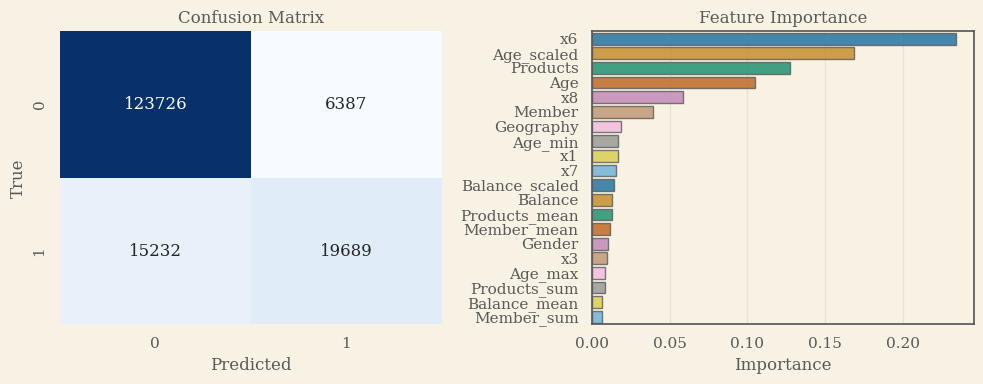

In [41]:
sub[target] = xgb_proba

sub.to_csv('xgb.csv', index=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(xgb_cm, ax=axes[0], annot=True, fmt='d', cmap='Blues', cbar=False)
axes[0].set_title('Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.barplot(x=xgb_imp, y=xgb_col, ax=axes[1], orient='h', palette=palette, edgecolor='#595959', alpha=0.8)
axes[1].set_title('Feature Importance'); axes[1].set_xlabel('Importance'); axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## <div style="text-align:center;padding:10px;color:Sienna;font-size:32px;font-family:Roboto Condensed;background-color:Seashell;margin:0;overflow:hidden;border:2px solid Sienna;border-radius:5px;">09 - Model - Selection</div>

In [42]:
auc_folds = []

for i, (x_train, x_valid, y_train, y_valid) in enumerate(folds):

    valid_fold = (
        np.array(lgb_valid[i])
        + np.array(xgb_valid[i])
                ) / 2

    auc_fold = roc_auc_score(y_valid, valid_fold)
    auc_folds.append(auc_fold)

round(np.mean(auc_folds),5)

0.89614

In [43]:
average_proba = (
    lgb_proba
    + xgb_proba
            ) / 2

sub[target] = average_proba

sub.to_csv("submission.csv",index=False)

<div style="text-align:center;padding:20px;color:Seashell;font-size:48px;font-family:Roboto Condensed;background-color:Sienna;margin:0;overflow:hidden;border:4px solid Seashell;border-radius:10px;"></div>